In [ ]:
!git clone https://github.com/openai/point-e.git

Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 57 (delta 5), reused 3 (delta 3), pack-reused 39
Unpacking objects: 100% (57/57), done.


In [ ]:
%cd point-e
!pip install -e .

/content/point-e
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/point-e
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-d_f18306/clip_6de61515c1e54b33b0bac6bc4416e0dc
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-install-d_f18306/clip_6de61515c1e54b33b0bac6bc4416e0dc
     |████████████████████████████████| 88 kB 7.2 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=e4cb331e800056c8875efc2e566684cec6d0925d8595273282e2ad24a3268faa
  Stored in directory: /tmp/pip-ephem-wheel-cache-s9eb313v/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=115175622ff2b4136e21b9e6b7dff2cce62339ce7c5eebbd6584ca1ecc0d840f
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddf

# Image to points cloud

In [ ]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|███████████████████████████████████████| 890M/890M [00:13<00:00, 67.1MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [ ]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [ ]:
# Load an image to condition on.
img = Image.open('/content/point-e/point_e/examples/example_data/cube_stack.jpg')

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

0it [00:00, ?it/s]

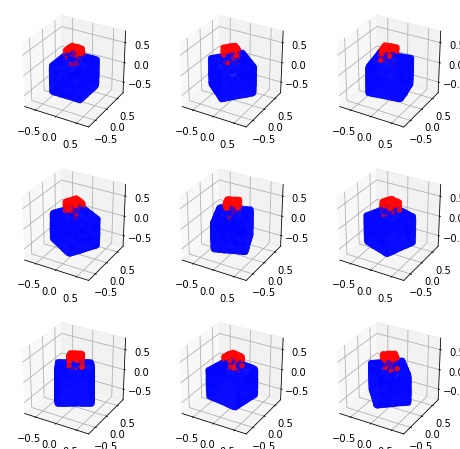

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

# Text to points cloud

In [ ]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|████████████████████████████████████████| 890M/890M [00:03<00:00, 277MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/161M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [ ]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [ ]:
# Set a prompt to condition on.
prompt = 'a laptop'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

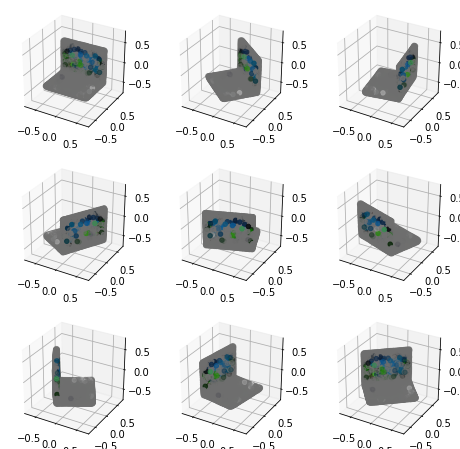

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

# Points cloud to mesh

In [ ]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud
import skimage.measure

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

creating SDF model...
loading SDF model...


<All keys matched successfully>

In [ ]:
#pc = PointCloud.load('/content/point-e/point_e/examples/example_data/pc_corgi.npz')

# Plot the point cloud as a sanity check.
#fig = plot_point_cloud(pc, grid_size=2)

In [ ]:
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=32, # increase to 128 for resolution used in evals
    progress=True,
)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
# Write the mesh to a PLY file to import into some other program.
with open('laptop.ply', 'wb') as f:
    mesh.write_ply(f)